In [2]:
import tensorboard
import tensorflow as tf 
import tensorflow.keras as keras
import numpy as np 
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA,TruncatedSVD, PCA
from sklearn.model_selection import train_test_split  
import pandas as pd 
import os 
from pathlib import Path
import random
from IPython import display as ipd

In [11]:
BASE_PATH = Path('/net/store/cv/users/ybrima/scratch/data/archive/16000_pcm_speeches')
OUT_PATH = Path('/net/store/cv/users/ybrima/scratch/data/archive/')
CLASSES =  ['Julia_Gillard','Nelson_Mandela','Jens_Stoltenberg','Magaret_Tarcher','Benjamin_Netanyau']

In [4]:
files = []
ds = {'file':[], "duration": [], "sr": [], 'class': [], 'label': []}
for c in CLASSES:
  if(os.path.isdir(Path(BASE_PATH, c))):
    path =  Path(BASE_PATH, c)
    for file in path.glob("*.wav"):
      ds['file'].append(file)
      y,sr = librosa.load(str(file), sr=None)
      ds['duration'].append(librosa.get_duration(y,sr))
      ds['sr'].append(sr)
      ds['class'].append(CLASSES.index(c))
      ds['label'].append(c)
df =  pd.DataFrame(ds)

In [5]:
df.head()

file  duration     sr  class  \
0  /net/store/cv/users/ybrima/scratch/data/archiv...       1.0  16000      0   
1  /net/store/cv/users/ybrima/scratch/data/archiv...       1.0  16000      0   
2  /net/store/cv/users/ybrima/scratch/data/archiv...       1.0  16000      0   
3  /net/store/cv/users/ybrima/scratch/data/archiv...       1.0  16000      0   
4  /net/store/cv/users/ybrima/scratch/data/archiv...       1.0  16000      0   

           label  
0  Julia_Gillard  
1  Julia_Gillard  
2  Julia_Gillard  
3  Julia_Gillard  
4  Julia_Gillard

In [6]:
HOP_SIZE =  512
FRAME_SIZE =  1024

In [7]:
r = df.sample(n=1)
f = df.iloc[r.index[0],0]
ipd.Audio(str(f))

In [8]:
def display(df,n=6,flag =  False):
  r = df.sample(n=n)
  plt.figure(1,figsize=(24,6))
  for i in range(r.shape[0]):
    l =  df.iloc[i]
    y,sr =  librosa.load(l[0], sr=None)
    plt.subplot(2,3,i+1)
    if(flag ==  False):
      librosa.display.waveplot(y,sr=sr)
      plt.xlabel("time")
      plt.ylabel("amplitude")
    else:
      D = librosa.stft(y,hop_length=HOP_SIZE,n_fft= FRAME_SIZE)  # STFT of y
      S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
      librosa.display.specshow(S_db,sr=sr,y_axis='mel', x_axis='time', hop_length=HOP_SIZE)
    plt.title(l[4])
  plt.tight_layout()
  plt.show()

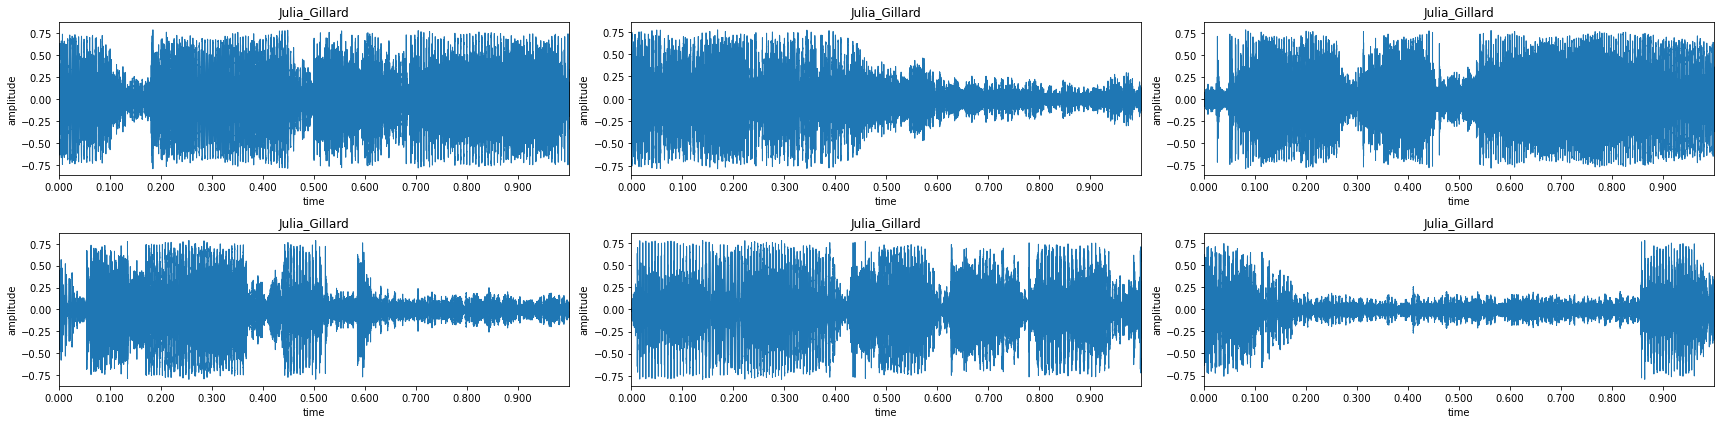

In [9]:
display(df)

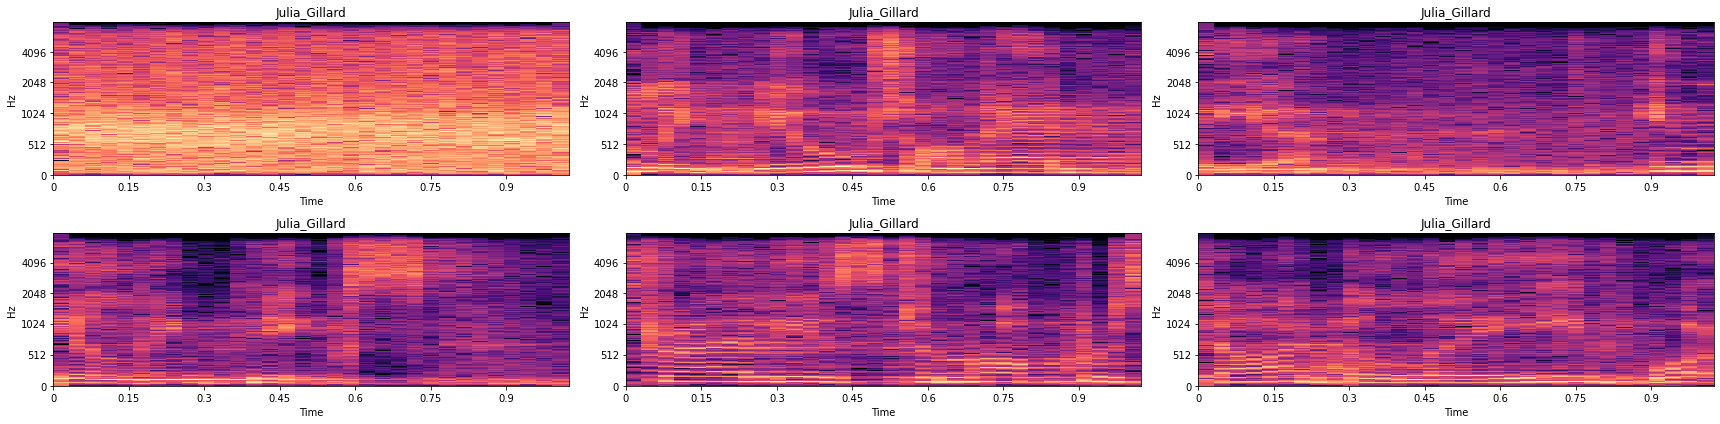

In [139]:
display(df, flag=True)

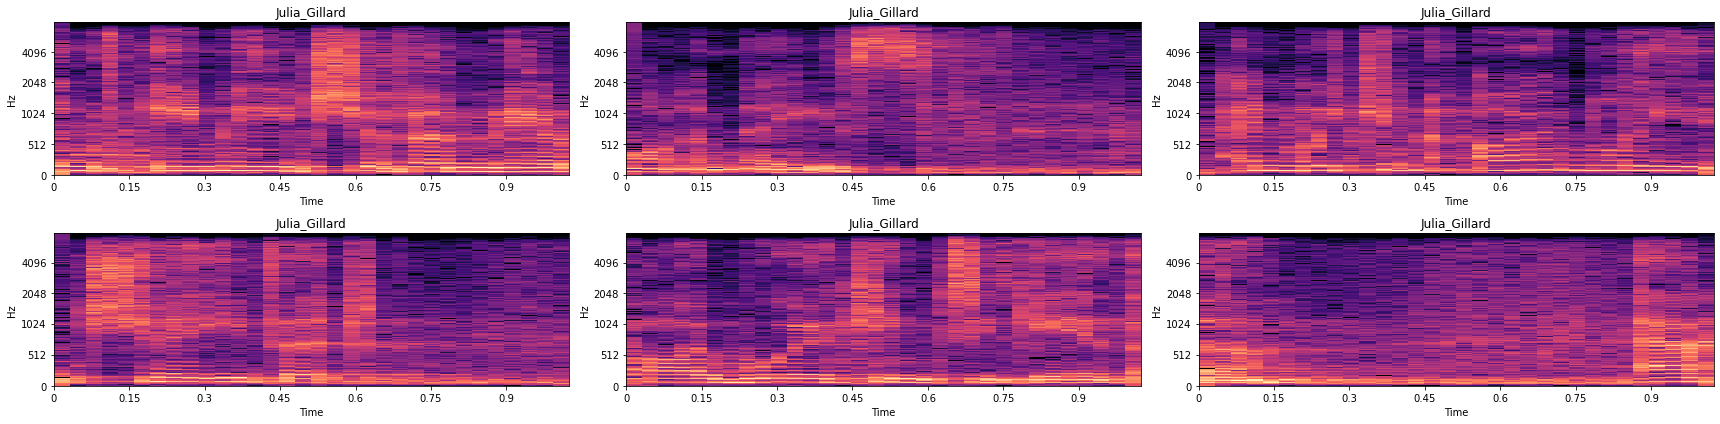

In [10]:
display(df, flag=True)

In [12]:

def make_dataset(df):
  X = list()
  y =  list()
  for i in range(df.shape[0]):
    l =  df.iloc[i]
    signal,sr =  librosa.load(l[0], sr=None)
    D = librosa.stft(signal,hop_length=HOP_SIZE,n_fft= FRAME_SIZE//2)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    X.append(S_db)
    y.append(l[3])
  np.savez(Path(OUT_PATH,'speeches.npz'),x = np.array(X), y = np.array(y))
  return np.array(X), np.array(y)

In [13]:
X,y = make_dataset(df)

In [14]:
pca = PCA(n_components=3)
X_pca =  pca.fit_transform(X.reshape(X.shape[0],-1))

In [19]:
%matplotlib widget

In [17]:
from scipy.ndimage.measurements import label
def plot_components(X_pca, x_str='Component 1', y_str='Component 2',z_str='Component 3'):
  fig = plt.figure(1,figsize=(10,6))
  ax =  fig.add_subplot(111,projection='3d')
  scatter = ax.scatter3D(X_pca[:,0],X_pca[:,1],X_pca[:,2], c=list(y))
  ax.set_xlabel(x_str)
  ax.set_ylabel(y_str)
  ax.set_zlabel(z_str)
  ax.legend(handles=scatter.legend_elements()[0], labels=CLASSES,bbox_to_anchor=(1.3, 1.0))
  plt.show()

In [18]:
plot_components(X_pca)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [220]:
svd = TruncatedSVD(n_components=3)
X_svd =  svd.fit_transform(X.reshape(X.shape[0],-1))

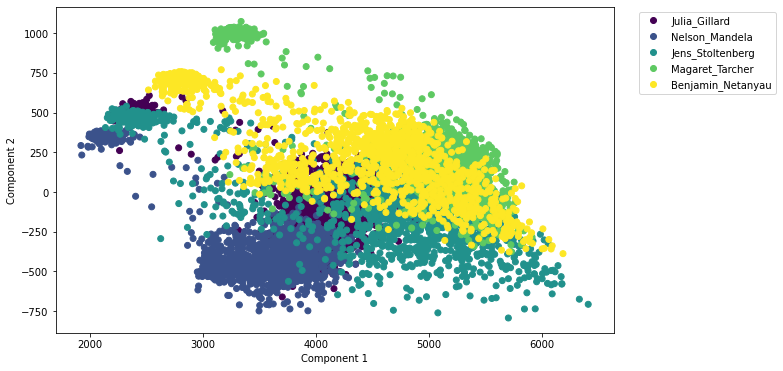

In [221]:
plot_components(X_svd)

In [234]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="val accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="val error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [99]:
def make_model(input_shape,output):

    model =  keras.models.Sequential([
        keras.layers.Dense(32, input_shape=input_shape, kernel_regularizer=keras.regularizers.L2(0.03), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, padding="same"),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, padding="same"),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, padding="same"),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, padding="same"),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2),strides=2, padding="same"),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(output, activation="softmax")

    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model


In [223]:
input_shape =  (X.shape[1],X.shape[2],1)
output =  len(CLASSES)

In [224]:
model  = make_model(input_shape,output)

In [227]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

In [228]:
history =  model.fit(x=X_train,y=y_train, batch_size=32, epochs=10, validation_split=0.2,verbose=1)

Epoch 1/10
150/150 [==============================] - 146s 957ms/step - loss: 0.6819 - accuracy: 0.7483 - val_loss: 2.0709 - val_accuracy: 0.0042
Epoch 2/10
150/150 [==============================] - 143s 956ms/step - loss: 0.3594 - accuracy: 0.8600 - val_loss: 2.1907 - val_accuracy: 0.0083
Epoch 3/10
150/150 [==============================] - 102s 679ms/step - loss: 0.2785 - accuracy: 0.8877 - val_loss: 2.7710 - val_accuracy: 0.0083
Epoch 4/10
150/150 [==============================] - 106s 705ms/step - loss: 0.2336 - accuracy: 0.9087 - val_loss: 3.0354 - val_accuracy: 0.0333
Epoch 5/10
150/150 [==============================] - 96s 639ms/step - loss: 0.2374 - accuracy: 0.9062 - val_loss: 4.2234 - val_accuracy: 0.0000e+00
Epoch 6/10
150/150 [==============================] - 130s 872ms/step - loss: 0.2199 - accuracy: 0.9131 - val_loss: 4.8343 - val_accuracy: 0.0000e+00
Epoch 7/10
150/150 [==============================] - 90s 601ms/step - loss: 0.1874 - accuracy: 0.9310 - val_loss: 4.

In [229]:
def resnet(input_shape,output):
    inputs = keras.Input(shape=input_shape, name="img")
    x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
    x = keras.layers.Conv2D(64, 3, activation="relu")(x)
    block_1_output = keras.layers.MaxPooling2D(3)(x)

    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    block_2_output = keras.layers.add([x, block_1_output])

    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    block_3_output = keras.layers.add([x, block_2_output])

    x = keras.layers.Conv2D(64, 3, activation="relu")(block_3_output)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    
    outputs =  keras.layers.Dense(output,activation="softmax")(x)

    model =  keras.Model(inputs=inputs,outputs=[outputs],name="toy_resnet")
    model.compile(
        loss=["sparse_categorical_crossentropy"],
        optimizer=keras.optimizers.RMSprop(1e-3),
        metrics = ["accuracy"]
        )
    return model

In [230]:
model = resnet(input_shape,output)

In [231]:
history =  model.fit(x=X_train,y=y_train, batch_size=32, epochs=3, validation_split=0.2,verbose=1)

Epoch 1/3
150/150 [==============================] - 234s 2s/step - loss: 1.4389 - accuracy: 0.3327 - val_loss: 2.9481 - val_accuracy: 0.0000e+00
Epoch 2/3
150/150 [==============================] - 228s 2s/step - loss: 1.1587 - accuracy: 0.4963 - val_loss: 1.9425 - val_accuracy: 0.0050
Epoch 3/3
150/150 [==============================] - 208s 1s/step - loss: 0.8004 - accuracy: 0.6992 - val_loss: 2.1691 - val_accuracy: 0.1575


In [232]:
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16, ResNet50

In [233]:
base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=x)
optim_params = dict(learning_rate = 0.0003,momentum = 0.9394867962846013,decay = 0.0001)
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.SGD(**optim_params),metrics=['accuracy'])

In [235]:
history =  model.fit(x=X_train,y=y_train, batch_size=32, epochs=3, validation_split=0.2,verbose=1)

Epoch 1/3
150/150 [==============================] - 1746s 12s/step - loss: 1.1412 - accuracy: 0.4777 - val_loss: 1.8413 - val_accuracy: 0.1567
Epoch 2/3
150/150 [==============================] - 1696s 11s/step - loss: 0.5068 - accuracy: 0.7950 - val_loss: 0.2823 - val_accuracy: 0.8700
Epoch 3/3
150/150 [==============================] - 1715s 11s/step - loss: 0.2494 - accuracy: 0.9023 - val_loss: 0.2034 - val_accuracy: 0.9450


In [235]:
plot_history(history)